# Results of emulation of different max-min fairness policies

These experiments use accumulated deficits to try to ensure that applications always receive their computed allocation of GPU time, even in the event of new jobs coming in and old jobs finishing, by keeping track of the difference between the GPU time the application should have received, and the GPU time the application actually received. Allocation of jobs to GPUs is performed in a round-based fashion, with GPUs instructed to run jobs for a fixed interval of time on all GPUs.

# Import statements

In [1]:
# Imports for plotting.
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
rc('text',
   usetex=True)
sns.set_style('ticks')
font = {
    'font.family':'Times New Roman',
    'font.weight': 200,
    'font.size': 10,
}
sns.set_style(font)
flatui = ['#002A5E', '#FD151B', '#8EBA42', '#348ABD', '#988ED5', '#BDB76B', '#8EBA42', '#FFB5B8']
sns.set_palette(flatui)
paper_rc = {
    'lines.linewidth': 2,
    'lines.markersize': 10,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.bf': 'Times New Roman:bold',
}
sns.set_context("paper", font_scale=2,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
# Other imports.
import os
import re

# Get logfile paths

In [3]:
def get_logfile_paths_helper(directory_name):
    logfile_paths = []
    for root, _, file_names in os.walk(directory_name):
        if len(file_names) > 0:
            logfile_paths.extend(
                [os.path.join(root, file_name)
                 for file_name in file_names])
    return logfile_paths

def get_logfile_paths(directory_name):
    logfile_paths = []
    for logfile_path in get_logfile_paths_helper(directory_name):
        m = re.match(
            r'.*v100=(\d+)\.p100=(\d+)\.k80=(\d+)/(.*)/seed=(\d+)/'
             'lambda=(\d+\.\d+)\.log', logfile_path)
        v100s = int(m.group(1))
        p100s = int(m.group(2))
        k80s = int(m.group(3))
        policy = m.group(4)
        seed = int(m.group(5))
        l = float(m.group(6))
        logfile_paths.append((v100s, p100s, k80s, policy, seed,
                              l, logfile_path))
    return logfile_paths

In [4]:
policies = ["fifo", "isolated", "max_min_fairness",
            "max_min_fairness_packed"]
logfile_paths = sorted(get_logfile_paths("/lfs/1/keshav2/gpusched/scheduler/logs/2019-08-01/"))

# Plotting functions

In [5]:
def prune(logfile_paths, v100s, p100s, k80s, policy, seed=None):
    if seed is None:
        return sorted([(x[5], x[6], x[4]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy])
    else:
        return sorted([(x[5], x[6]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy and
                       x[4] == seed])

# Plot per-worker timelines

In [6]:
def get_events(logfile_path):
    events = {}
    utilization = None
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            m = re.match(r'(\d+\.\d+).*scheduled.*Job ID: (\d+)\t'
                          'Worker type: (.*)\tWorker ID: (\d+).*',
                         line)
            if m is not None:
                start_timestamp = float(m.group(1))
                job_id = int(m.group(2))
                worker_type = m.group(3)
                worker_id = int(m.group(4))
                if worker_id not in events:
                    events[worker_id] = []
                events[worker_id].append([job_id, worker_type, start_timestamp,
                                          None])
            m = re.match(r'(\d+\.\d+).*scheduled.*Job ID: \((\d+), (\d+)\)\t'
                          'Worker type: (.*)\tWorker ID: (\d+).*',
                         line)
            if m is not None:
                start_timestamp = float(m.group(1))
                job_id1 = int(m.group(2))
                job_id2 = int(m.group(3))
                worker_type = m.group(4)
                worker_id = int(m.group(5))
                if worker_id not in events:
                    events[worker_id] = []
                events[worker_id].append([(job_id1, job_id2), worker_type, start_timestamp,
                                          None])
            
            m = re.match(r'(\d+\.\d+).*succeeded.*Job ID: (\d+)\t'
                          'Worker type: (.*)\tWorker ID: (\d+).*',
                         line)
            if m is not None:
                end_timestamp = float(m.group(1))
                job_id = int(m.group(2))
                worker_type = m.group(3)
                worker_id = int(m.group(4))
                if worker_id not in events:
                    continue
                assert(events[worker_id][-1][0] == job_id and
                       events[worker_id][-1][1] == worker_type and
                       events[worker_id][-1][3] is None)
                events[worker_id][-1][3] = end_timestamp
                
            m = re.match(r'(\d+\.\d+).*succeeded.*Job ID: \((\d+), (\d+)\)\t'
                          'Worker type: (.*)\tWorker ID: (\d+).*',
                         line)
            if m is not None:
                end_timestamp = float(m.group(1))
                job_id1 = int(m.group(2))
                job_id2 = int(m.group(3))
                worker_type = m.group(4)
                worker_id = int(m.group(5))
                if worker_id not in events:
                    continue
                assert(events[worker_id][-1][0] == (job_id1, job_id2) and
                       events[worker_id][-1][1] == worker_type and
                       events[worker_id][-1][3] is None)
                events[worker_id][-1][3] = end_timestamp
                
            m = re.match(r'Cluster utilization: (\d+\.\d+)', line)
            if m is not None:
                utilization = float(m.group(1)) * 100.

    return events, utilization

def analyze_timeline(v100s, p100s, k80s, policy, start,
                     end, seed, max_lambda=None,
                     output_filename=None):
    relevant_logfile_paths = list(reversed(prune(
        logfile_paths, v100s, p100s, k80s, policy, seed)))
    for (lamb, relevant_logfile_path) in relevant_logfile_paths:
        if max_lambda is not None and lamb > max_lambda:
            continue
        events, utilization = get_events(relevant_logfile_path)

        if utilization is not None:
            print("Lambda = %.2f" % lamb)

            worker_id_to_type_mapping = {}
            time_occupied = {}
            max_end_timestamp = None
            for worker_id in events:
                time_occupied[worker_id] = 0
                for (job_id, worker_type, start_timestamp, end_timestamp) \
                    in events[worker_id]:
                    if worker_id not in worker_id_to_type_mapping:
                        worker_id_to_type_mapping[worker_id] = worker_type
                    if end_timestamp is None:
                        continue
                    time_occupied[worker_id] += (end_timestamp - start_timestamp)
                    if max_end_timestamp is None or max_end_timestamp < end_timestamp:
                        max_end_timestamp = end_timestamp
            per_worker_utilization = {
                (time_occupied[worker_id] * 100.0) / max_end_timestamp
                for worker_id in time_occupied
            }
            print(worker_id_to_type_mapping)
            print("Utilization: %.3f%%" % utilization)
            print(per_worker_utilization)

labels = {"fifo": "FIFO", "isolated": "MMF", "max_min_fairness": "MMF+perf",
          "max_min_fairness_packed": "MMF+perf+packed"}
def plot_timeline(v100s, p100s, k80s, policy, start,
                  end, seed, max_lambda=None,
                  output_filename=None):
    relevant_logfile_paths = list(reversed(prune(
        logfile_paths, v100s, p100s, k80s, policy, seed)))
    for (lamb, relevant_logfile_path) in relevant_logfile_paths:
        if max_lambda is not None and lamb > max_lambda:
            continue
        events, utilization = get_events(relevant_logfile_path)

        if utilization is not None:
            print("Lambda = %.2f" % lamb)
            plt.figure(figsize=(25, 6))
            ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

            worker_id_to_type_mapping = {}
            for worker_id in events:
                for (job_id, worker_type, start_timestamp, end_timestamp) \
                    in events[worker_id]:
                    if worker_id not in worker_id_to_type_mapping:
                        worker_id_to_type_mapping[worker_id] = worker_type
                    if end_timestamp is None:
                        continue
                    if end_timestamp >= start and start_timestamp < end:
                        if isinstance(job_id, tuple):
                            ax.plot([start_timestamp, min(end_timestamp, end)],
                                    [worker_id, worker_id],
                                    linewidth=10, c="yellow")
                        else:
                            ax.plot([start_timestamp, min(end_timestamp, end)],
                                    [worker_id, worker_id],
                                    linewidth=10, c="C%d" % (job_id % 10))
            print(worker_id_to_type_mapping)
            print("Utilization: %.3f%%" % utilization)

        ax.set_xlabel("Time")
        ax.set_ylabel("Worker ID")
        worker_ids = list(events.keys())
        
        ax.set_yticks(worker_ids)
        ax.set_yticklabels([str(worker_id) for worker_id in worker_ids])
        sns.despine()

        if output_filename is not None:
            with PdfPages(output_filename) as pdf:
                pdf.savefig(bbox_inches='tight')

        plt.show()

V100s=25, P100s=0, K80s=0; Max-Min Fairness with packing
Lambda = 4114.29
{0: 'v100', 1: 'v100', 2: 'v100', 3: 'v100', 4: 'v100', 5: 'v100', 6: 'v100', 7: 'v100', 8: 'v100', 9: 'v100', 10: 'v100', 11: 'v100', 12: 'v100', 13: 'v100', 14: 'v100', 15: 'v100', 16: 'v100', 17: 'v100', 18: 'v100', 19: 'v100', 20: 'v100', 21: 'v100', 22: 'v100', 23: 'v100', 24: 'v100'}
Utilization: 87.200%
{99.04352362607219, 99.97547490103824, 99.90190055104074, 99.95912495342473, 99.99182496701275, 99.93460020954588, 99.88555072178816, 99.79562654253809, 99.75475149596282, 99.74657646297557, 99.72205136401382, 99.68935123206484, 99.64030103414134, 99.59125083621785, 99.57490077024333, 99.5503756712816, 99.41957514348564, 99.38687501153665, 99.35417487958766, 99.26424951672792, 99.16614912088092}
Lambda = 4114.29
{0: 'v100', 1: 'v100', 2: 'v100', 3: 'v100', 4: 'v100', 5: 'v100', 6: 'v100', 7: 'v100', 8: 'v100', 9: 'v100', 10: 'v100', 11: 'v100', 12: 'v100', 13: 'v100', 14: 'v100', 15: 'v100', 16: 'v100', 17:

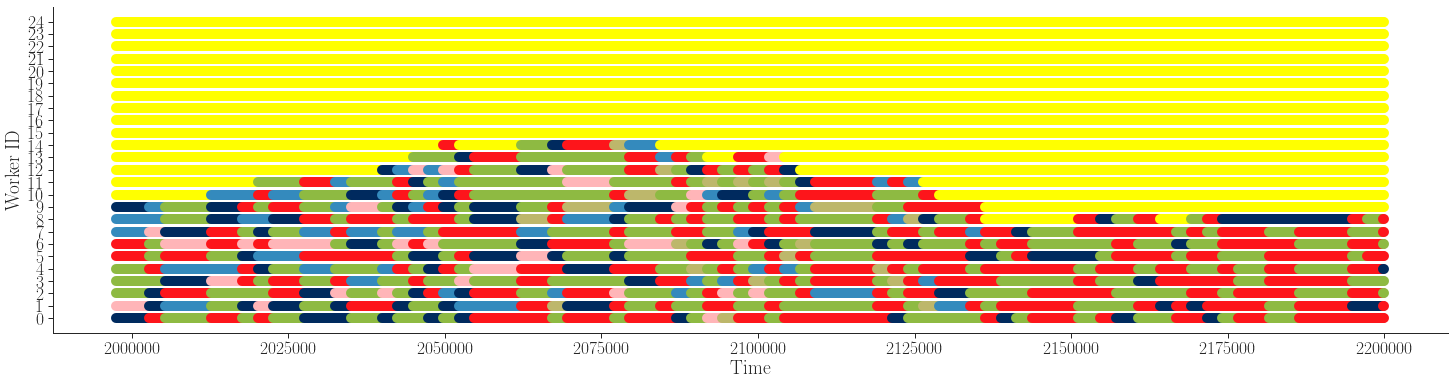

<Figure size 432x288 with 0 Axes>

In [7]:
print("V100s=25, P100s=0, K80s=0; Max-Min Fairness with packing")
analyze_timeline(
    v100s=25, p100s=0, k80s=0, start=2000000,
    end=2200000, seed=0, max_lambda=4200,
    policy="max_min_fairness_packed"
)
plot_timeline(
    v100s=25, p100s=0, k80s=0, start=2000000,
    end=2200000, seed=0, max_lambda=4200,
    policy="max_min_fairness_packed"
)